<a href="https://colab.research.google.com/github/riteshpen/Tomato_Plant_Health/blob/main/website_test/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
import tensorflow as tf
from keras import models, layers, applications
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [26]:


# Load dataset
dataset_path = '/content/drive/My Drive/Colab Notebooks/PlantVillage'
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 1

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names

# Stratified dataset partitioning
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1):
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

# Pre-trained model
base_model = applications.EfficientNetB0(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
                                         include_top=False,
                                         weights='imagenet')
base_model.trainable = False  # Freeze the base model


Found 4620 files belonging to 3 classes.


116/116 ━━━━━━━━━━━━━━━━━━━━ 581s 5s/step - accuracy: 0.6070 - loss: 0.8297 - val_accuracy: 0.8862 - val_loss: 0.3083
15/15 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.9210 - loss: 0.2735
Test Accuracy: 0.904347836971283
15/15 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step


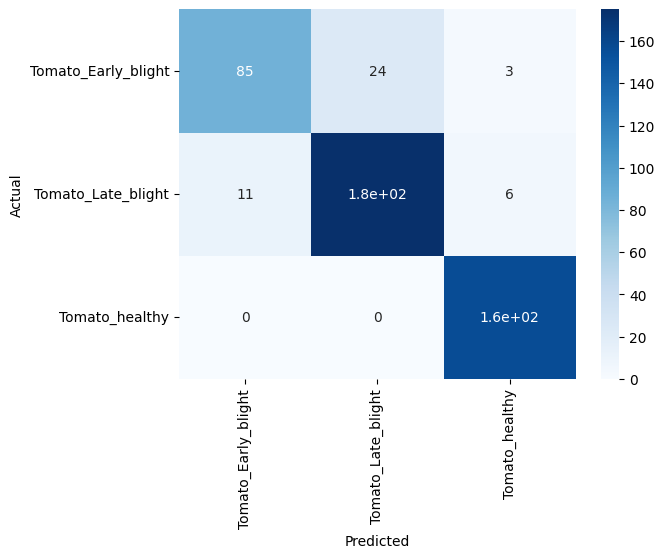

                     precision    recall  f1-score   support

Tomato_Early_blight       0.89      0.76      0.82       112
 Tomato_Late_blight       0.88      0.91      0.90       192
     Tomato_healthy       0.95      1.00      0.97       156

           accuracy                           0.90       460
          macro avg       0.90      0.89      0.89       460
       weighted avg       0.90      0.90      0.90       460



In [27]:
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.concatenate([y for x, y in dataset])),
    y=np.concatenate([y for x, y in dataset])
)

# Convert class weights array to dictionary
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Training the model with class weights
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight_dict  # Use the dictionary here
)
# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")

# Plotting the confusion matrix
y_true = np.concatenate([y for x, y in test_ds])
y_pred = np.argmax(model.predict(test_ds), axis=-1)

conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


In [29]:
model_version = "4"
model_path = f'/content/drive/My Drive/Colab Notebooks/tomato-disease/models/model_{model_version}.weights.h5' # Added '_weights' to filename
model.save_weights(model_path)